# 1. 1D Convnet

### 입력 시퀀스에서 시간 축으로 패치를 추출하여 출력 타임스텝을 만든다.

- 1D Convnet은 특정 시퀀스 처리에서 RNN과 견줄만하다. 일반적으로 계산 비용이 싸다. 1D 컨브넷은 팽창된 커널(dilated_kernel)과 함꼐 사용된다. 최근에 오디오 생성과 기계 번역에서 큰 성공을 거두었다. 텍스트 분류나 시계열 예측 같은 간단한 문제에서 1D 컨브넷이 RNN을 대신해서 빠르게 처리할 수 있다.

- 1D Convent은 시퀀스에 있는 지역 패턴을 인식할 수 있다. 동일한 변환이 시퀀스에 있는 모든 패치에 적용되기 때문에 특정 위치에서 학습한 패턴을 나중에 다른 위치에서 인식할 수 있다. 이는 1D 컨브넷 이동 불변성을 제공합니다. (translation invariant)

- 예를 들어서 크기 5인 윈도우를 사용하여 문자 시퀀스를 처리하는 1D 컨브넷은 5개 이하의 단어나 단어의 부분을 학습합니다. 이 컨브넷은 이 다넝가 입력 시퀀스 어느 문장에 있떠라도 인식할 수 있습니다. 따라서 문자 수준의 1D 컨브넷은 단어 형태학에 관해 학습할 수 있습니다.

# 2. 시퀀스 데이터를 위한 1D 풀링

- 컨브넷에서 이미지 텐서 크기를 다운샘플링 하기 위해 사용하는 평균 풀링이나 맥스 풀링 같은 2D 연산을 배웠습니다. 1D 풀링 연산은 2D 풀링 연산과 동일합니다. 입력에서 1D 패치 부분을 추출하고 최대값을 출력하고 평균값을 출력합니다.

# 3. 1D Convnet 구현

- Conv1D는 (samples, time, features) 크기의 3D 텐서를 입력받고 비슷한 형태의 3D 

In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500

print("데이터 로드...")
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features) 
print(len(x_train), "훈련 시퀀스")
print(len(x_test), "테스트 시퀀스")

데이터 로드...
25000 훈련 시퀀스
25000 테스트 시퀀스


In [3]:
print("시퀀스 패딩(samples x time)")
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train 크기: ', x_train.shape)
print('x_test 크기: ', x_test.shape)

시퀀스 패딩(samples x time)
x_train 크기:  (25000, 500)
x_test 크기:  (25000, 500)


### 1D 컨브넷은 5장에서 사용한 2D 컨브넷과 비슷한 방식으로 구성합니다.
- Conv1D와 MaxPooling1D 층을 쌓고 전역 풀링층이나 Flatten 층으로 마칩니다.

<img src="./1dconvnet.png">

In [5]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [6]:
model = Sequential()

model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))

# 시간 축 따라서 pooling
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))

# 시간 축 전체에 적용(samples, timesteps, features) > (samples, features)
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer=RMSprop(lr=1e-4), 
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 5s 244us/step - loss: 0.7013 - acc: 0.5281 - val_loss: 0.6844 - val_acc: 0.5706
Epoch 2/10
20000/20000 [==============================] - 2s 89us/step - loss: 0.6630 - acc: 0.6742 - val_loss: 0.6638 - val_acc: 0.6590
Epoch 3/10
20000/20000 [==============================] - 3s 174us/step - loss: 0.6175 - acc: 0.7659 - val_loss: 0.6081 - val_acc: 0.7410
Epoch 4/10
20000/20000 [==============================] - 1s 74us/step - loss: 0.5199 - acc: 0.8111 - val_loss: 0.4894 - val_acc: 0.7976
Epoch 5/10
20000/20000 [==============================] - 1s 75us/step - loss: 0.4134 - acc: 0.8437 - val_loss: 0.4364 - val_acc: 0.8258
Epoch 6/10
20000/20000 [==============================] - 1s 74us/step - loss: 0.3458 - acc: 0.8689 - val_loss: 0.4118 - val_acc: 0.8428
Epoch 7/10
20000/20000 [==============================] - 1s 73us/step - loss: 0.3024 - acc: 0.8799 - val_loss: 0.4000 - val_ac

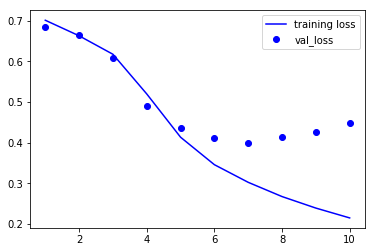

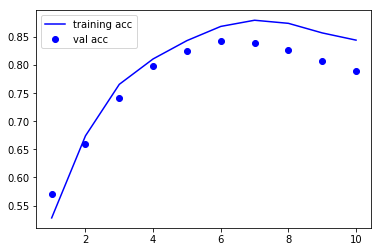

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

training_loss = history.history['loss']
val_loss = history.history['val_loss']

x = range(1, 11)

plt.plot(x, training_loss, 'b', label='training loss')
plt.plot(x, val_loss, 'bo', label='val_loss')
plt.legend()

plt.show()

training_loss = history.history['acc']
val_loss = history.history['val_acc']

x = range(1, 11)

plt.plot(x, training_loss, 'b', label='training acc')
plt.plot(x, val_loss, 'bo', label='val acc')
plt.legend()

plt.show()

## 4. 기온 예측

### 1. 데이터 정리하기

In [29]:
import os

data_dir = './datasets/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

In [30]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [31]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

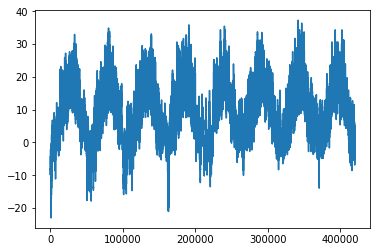

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

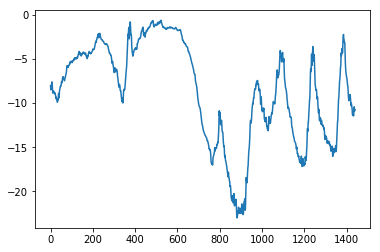

In [33]:
plt.plot(range(1440), temp[:1440])

### 2. 데이터 전처리

In [34]:
# Standardization
mean = float_data[:200000].mean(axis=0)
float_data -= mean

std = float_data[:200000].std(axis=0)
float_data /= std

### 3. Generator 생성

In [35]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    """
    data: data
    lookback: 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
    delay: 타깃으로 사용할 미래의 타임스텝
    min_index와 max_index: 추출할 타임스텝 범위를 지정하기 위한 data 배열의 인덱스, 검증 데이터와 테스트 데이터를 분리하는 데 사용합니다.
    shuffle: 샘플을 섞을지, 시간 순서대로 추출할 지 결정한다
    batch_size: 배치 샘플 수
    step: 데이터를 샘플링할 타임스텝 간격, 1시간에 하나의 데이터 포인트 추출을 위해 6으로 지정한다.
    """
    
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size
            )
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            
            # batch_size 만큼 뽑는다.
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        # empty
        samples = np.zeros((len(rows),
                            lookback//step,
                            data.shape[-1]))
        targets = np.zeros((len(rows), ))
        
        for j, row in enumerate(rows):
            # step 간격으로 추출
            indices = range(rows[j] - lookback, rows[j], step)
            
            # sample (128, 240, 14)
            samples[j] = data[indices]
            
            # target (128,)
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [36]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [37]:
train_gen = generator(float_data, 
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data, 
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step, 
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### 4. 1D Convnet

- 1D 컨브넷이 입력 패치를 독립적으로 처리하기 때문에 RNN과 다릴 타임스텝의 순서에 민감하지 않습니다. 물론 장기간의 패턴을 인식하기 위해 많은 합성곱 층과 풀링 층을 쌓을 수 있습니다. 상위 층은 원본 입력에서 긴 범위를 보게 될 것입니다.

In [38]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()

# filter 개수, filter size
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))

# timestep 별 pooling
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))

# 전체 timestep에 대해서 pooling
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 16s 32ms/step - loss: 0.4184 - val_loss: 0.4496
Epoch 2/20
500/500 [==============================] - 15s 29ms/step - loss: 0.3614 - val_loss: 0.4704
Epoch 3/20
500/500 [==============================] - 15s 30ms/step - loss: 0.3348 - val_loss: 0.4614
Epoch 4/20
500/500 [==============================] - 15s 29ms/step - loss: 0.3172 - val_loss: 0.4763
Epoch 5/20
500/500 [==============================] - 15s 30ms/step - loss: 0.3062 - val_loss: 0.4859
Epoch 6/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2948 - val_loss: 0.4826
Epoch 7/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2839 - val_loss: 0.4831
Epoch 8/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2791 - val_loss: 0.4630
Epoch 9/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2745 - val_loss: 0.4874
Epoch 10/20
500/500 [==============================] - 16s 32ms/step - loss: 0.267

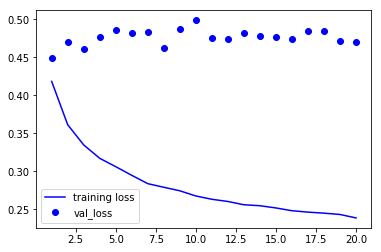

In [43]:
from matplotlib import pyplot as plt
%matplotlib inline

training_loss = history.history['loss']
val_loss = history.history['val_loss']

x = range(1, 21)

plt.plot(x, training_loss, 'b', label='training loss')
plt.plot(x, val_loss, 'bo', label='val_loss')
plt.legend()

plt.show()

### 5. CNN과 RNN을 연결하여 긴 시퀀스 처리하기

In [44]:
step = 3
lookback = 1440
delay = 144

In [45]:
train_gen = generator(float_data, 
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data, 
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step, 
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [47]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model= Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 172s 344ms/step - loss: 0.3339 - val_loss: 0.2813
Epoch 2/20
500/500 [==============================] - 171s 342ms/step - loss: 0.3012 - val_loss: 0.2717
Epoch 3/20
500/500 [==============================] - 167s 335ms/step - loss: 0.2902 - val_loss: 0.2810
Epoch 4/20
500/500 [==============================] - 169s 338ms/step - loss: 0.2790 - val_loss: 0.2831
Epoch 5/20
500/500 [==============================] - 171s 343ms/step - loss: 0.2730 - val_loss: 0.2758
Epoch 6/20
500/500 [==============================] - 175s 351ms/step - loss: 0.2668 - val_loss: 0.2729
Epoch 7/20
500/500 [==============================] - 167s 334ms/step - loss: 0.2592 - val_loss: 0.2876
Epoch 8/20
500/500 [==============================] - 170s 340ms/step - loss: 0.2551 - val_loss: 0.2785
Epoch 9/20
500/500 [==============================] - 171s 343ms/step - loss: 0.2519 - val_loss: 0.2790
Epoch 10/20
500/500 [==============================] - 170s 341m

## 5. 정리

- 2D 컨브넷이 2D 공간의 시각적 패턴을 잘 처리하는 것처럼 1D 컨브넷은 시간에 따른 패턴을 잘 처리합니다. 1D 컨븐세은 특정 자연어 처리 같은 문제에 RNN을 대신할 수 있는 빠른 모델입니다.

- 전형적으로 1D 컨븐셍느 컴퓨터 비전 분야의 2D 컨브넷과 비슷하게 구성합니다. Conv1D 층과 Maxpooling 1D를 쌓고 마지막에 전역 풀링 연산이나 Flatten 층을 둡니다.

- RNN으로 아주 긴 시퀀스를 처리하려면 계산 비용이 듭니다. 1D 컨브넷은 비용이 적게듭니다. 따라서 1D 컨브넷을 RNN 이전의 전처리 단계로 사용하는 것은 좋은생각입니다. 시퀀스 길이를 줄이고 RNN이 유용한 표현을 추출해줄 것입니다.

- 시퀀스 데이터에서 전반적인 순서가 중요하다면 순환 네트워크를 사용하여 처리하는 것이 좋습니다. 최근의 정보가 오래된 과거보다 더 중요한 시계열 데이터가 전형적인 경우입니다.

- 전반적인 순서가 없다면 1D 컨브넷이 적어도 동일한 성능을 내면서 비용도 적을 것입니다. 텍스트 데이터가 종종 이에 해당합니다. 문장 처음에 있는 키워드가 마지막에 있는 키워드와 같은 의미를 가집니다.